## Finite fault
In this example we demonstrate integrating finite faults into the implicit function. To run this example you need:
* LoopStructural
* lavavu
* matplotlib

If you are using google colab or you do not have these libraries installed uncomment the following line

In [1]:
#!pip install LoopStructural lavavu-osmesa matplotlib

In [53]:
from LoopStructural import GeologicalModel
from LoopStructural.visualisation import LavaVuModelViewer
from LoopStructural.datasets import value_headers, strike_dip_headers
from LoopStructural.utils.helper import strike_dip_vector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [54]:
# define the rotation of the lavavu visualisation
rotation = [-85.06083679199219, -6.958558082580566, -0.9042572379112244]
# container for image arrays
images = {}

## Define model data and bounding box

In [55]:
bb = np.array([[0,0,0],
               [10.,10,10]])
bb+=np.random.uniform(0,.1)
fault_value_data = pd.DataFrame([[5.3,5.4,9.2,0,0],
                                 [5.3,3.4,9.2,0,0],
#                                 [1,7,8,0,0],
                                [8,7,1,1,1],

                                [5.3,3.4,9.2,0,1],
#                                  [5.3,5.4,2.2,1,0]
#                                  [5,5,5,0,1],
                                 
# #                                  [7,7,7,1,1],
                                 [5,0,5,0,2],
                                 [5.2,0,5,0,2],

#                                  [5,10,5,1,2],
                                ],
                                columns=value_headers()+['coord'])
fault_value_data['feature_name'] = 'fault'
fault_strike_data = pd.DataFrame([[5,5,5,0,35,0],
                                  [8,5,1,0,0,0],
                                  [5,2,5,0,45,0],
                                  [8,2,1,0,0,0],
                                  [5,7,5,0,45,0],
                                  [8,7,1,0,0,0],
                                  [1,5,8,0,85,0],
                                  [1,2,8,0,85,0],
                                  [1,7,8,0,85,0],
#                                   [5,5,5,180,45,1],
#                                   [5,7,5,180,45,1],

                                 [5,5,5,90,90,2]
                                 ],
                                columns=strike_dip_headers()+['coord'])
fault_strike_data['feature_name'] = 'fault'
strati_data = pd.DataFrame([[5,5,5,0]],columns=value_headers())
strati_data['feature_name'] = 'strati'
strati_strike = pd.DataFrame([[5,5,5,0,0]],columns=strike_dip_headers())
strati_strike['feature_name'] = 'strati'
# combine all into a data frame
data = pd.concat([fault_strike_data,fault_value_data,strati_strike,strati_data],sort=False)
# Scale the normal vectors to change the shape of the ellipsoid, this could be done by defining tips using value constraints 
# of -1 and 1
data['nx'] = np.nan
data['ny'] = np.nan
data['nz'] = np.nan
data[['nx','ny','nz']] = strike_dip_vector(data['strike'],data['dip'])
data.drop(columns=['strike','dip'],inplace=True)
data.loc[data['coord']==0,['nx','ny','nz']]*=.3
data.loc[data['coord']==1,['nx','ny','nz']]*=.1
data.loc[data['coord']==2,['nx','ny','nz']]*=.4

In [56]:
data = data.reset_index()

### Set up the model

In [57]:
model = GeologicalModel(bb[0,:],bb[1,:])#,rescale=False)
model.set_model_data(data)
fault = model.create_and_add_fault('fault',
                                   1,
                                   nelements=1e4,
                                   regularisation=[.1,5,.1],
#                                    regularisation=[0.5,0.2,1],
                                   interpolatortype='FDI',
#                                    solver='pyamg',
                                   faultfunction='BaseFault',
#                                        cpw=100,
#                                    buffer=0.5,
#                                    damp=True,
#                                    step=10,
#                                    npw=10,
#                                     tol=1e-5
                                   solver='lu'
                                  )
strati = model.create_and_add_foliation('strati',
                                        nelements=1e4,
#                                         nelements=5000,
#                                         interpolatortype='FDI',
#                                         solver='pyamg',
                                        buffer=0.5)


2021-08-23 04:02:10,956 ~ LoopStructural.modelling.core.geological_model ~ WARNING    ~ Depreciated method. Model data can now be set using the data attribute
2021-08-23 04:02:10,956 ~ LoopStructural.modelling.core.geological_model ~ WARNING    ~ Depreciated method. Model data can now be set using the data attribute


In [58]:
model.update()

  0%|          | 0/4 [00:00<?, ?it/s]

## Visualise fault frame

In [59]:
viewer =  LavaVuModelViewer(model)

viewer.add_isosurface(fault[0],slices=[-1,0,1])
viewer.add_isosurface(fault[1],slices=[1,0,1],paint_with=fault[1])
viewer.add_isosurface(fault[2],slices=[-1,0,1],cmap='rainbow',vmin=0,vmax=1)#)
# viewer.add_scalar_field(fault[0])
# viewer.add_scalar_field(fault[1])
# viewer.add_isosurface(fault[1],nslices=10)
viewer.add_data(fault[1])
viewer.add_data(fault[0])
viewer.add_data(fault[2])

viewer.interactive()

2021-08-23 04:08:29,581 ~ LoopStructural.visualisation.model_visualisation ~ WARNING    ~ Isovalue doesn't exist inside bounding box
2021-08-23 04:08:29,581 ~ LoopStructural.visualisation.model_visualisation ~ WARNING    ~ Isovalue doesn't exist inside bounding box
2021-08-23 04:08:29,581 ~ LoopStructural.visualisation.model_visualisation ~ WARNING    ~ Isovalue doesn't exist inside bounding box


## Fault displacement figure


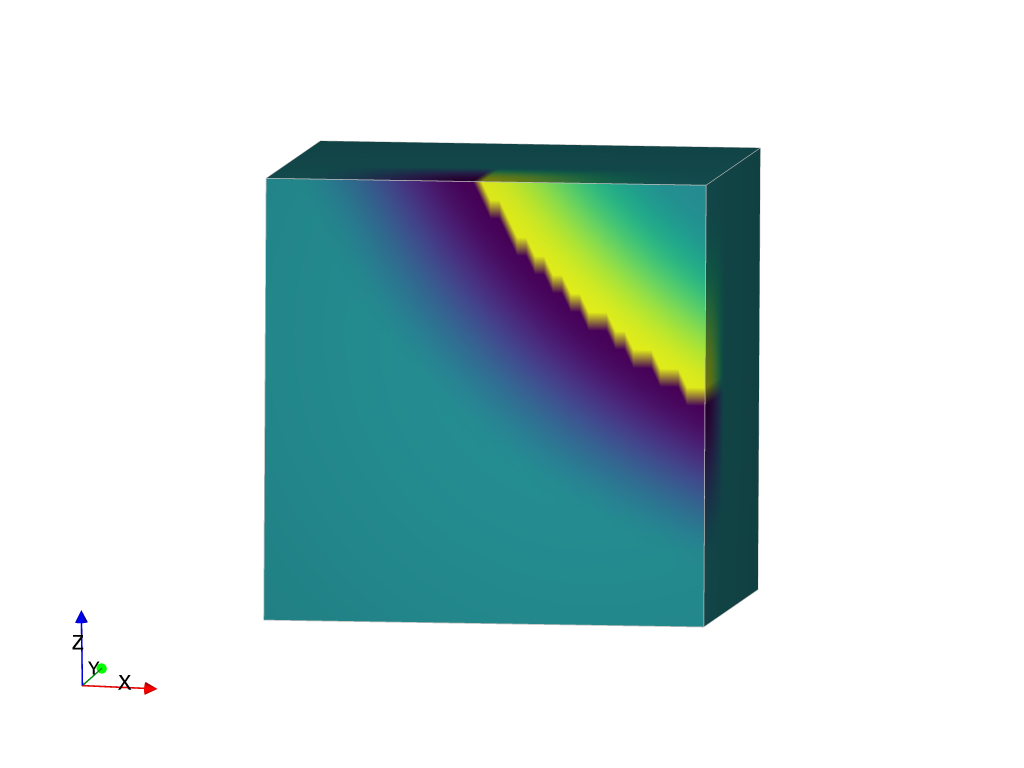

In [60]:
viewer = LavaVuModelViewer(model)

viewer.add_scalar_field(fault.displacementfeature,cmap='viridis')#,vmin=-1,xmax=1)
viewer.rotation = rotation
viewer.display()
images['fault_displacement'] = viewer.image_array()

### Faulted stratigraphy figure

In [61]:
# generate stratigraphic column
np.random.seed(0)
stratigraphic_column = {'strati':{}}
i = 0
# minimum = -12
minimum=-12
while minimum < 12:
    thickness = np.random.random()*2
    maximum=minimum+thickness
    c = np.ones(4)
    c[:3] = np.random.random(3)
    stratigraphic_column['strati']['unit_{}'.format(i)] = {'min':minimum,'max':maximum,'id':i,'colour':c}
    minimum=maximum
    i+=1
stratigraphic_column['faults'] = {}
model.set_stratigraphic_column(stratigraphic_column)


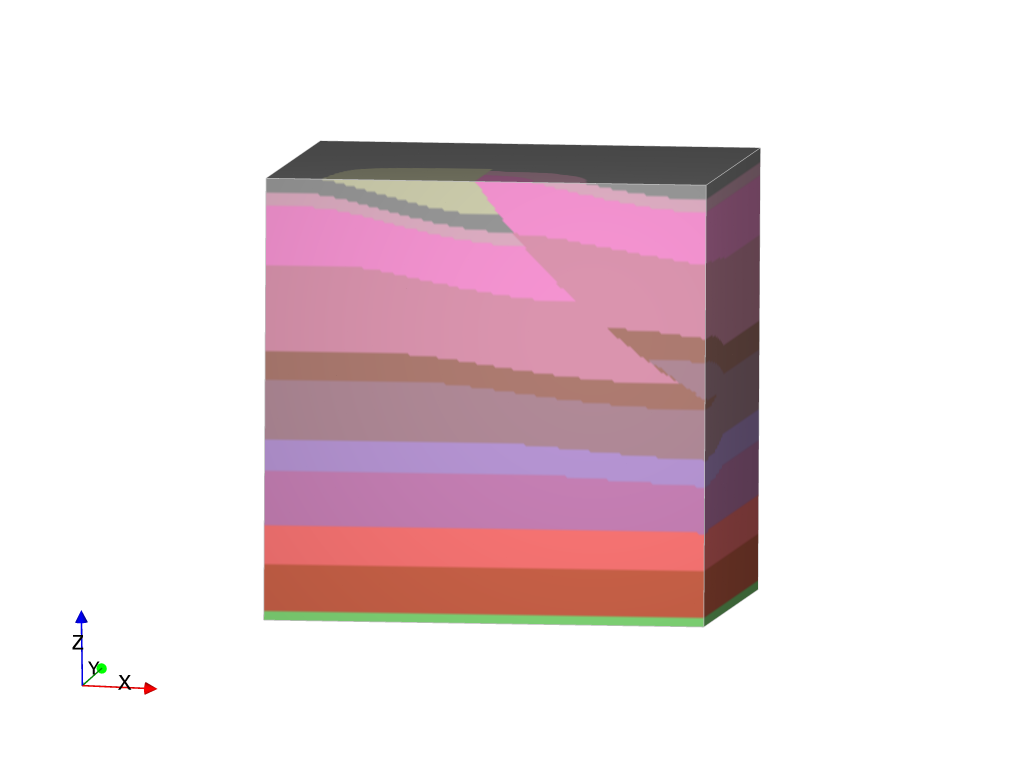

In [62]:
viewer = LavaVuModelViewer(model)
# viewer.nsteps = np.array([200,200,200])
viewer.nelements=5e6
viewer.add_model(cmap='tab20',vmin=1,vmax=21)
# viewer.add_scalar_field(f1_displacement_feature,cmap='rainbow')
viewer.rotation = rotation
viewer.display()
images['stratigraphy'] = viewer.image_array()

### Surfaces

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

2021-08-23 02:21:54,257 ~ LoopStructural.visualisation.model_visualisation ~ WARNING    ~ Isovalue doesn't exist inside bounding box
2021-08-23 02:21:54,257 ~ LoopStructural.visualisation.model_visualisation ~ WARNING    ~ Isovalue doesn't exist inside bounding box
2021-08-23 02:21:54,257 ~ LoopStructural.visualisation.model_visualisation ~ WARNING    ~ Isovalue doesn't exist inside bounding box
2021-08-23 02:21:54,259 ~ LoopStructural.visualisation.model_visualisation ~ WARNING    ~ Isovalue doesn't exist inside bounding box
2021-08-23 02:21:54,259 ~ LoopStructural.visualisation.model_visualisation ~ WARNING    ~ Isovalue doesn't exist inside bounding box
2021-08-23 02:21:54,259 ~ LoopStructural.visualisation.model_visualisation ~ WARNING    ~ Isovalue doesn't exist inside bounding box
2021-08-23 02:21:54,261 ~ LoopStructural.visualisation.model_visualisation ~ WARNING    ~ Isovalue doesn't exist inside bounding box
2021-08-23 02:21:54,261 ~ LoopStructural.visualisation.model_visualis


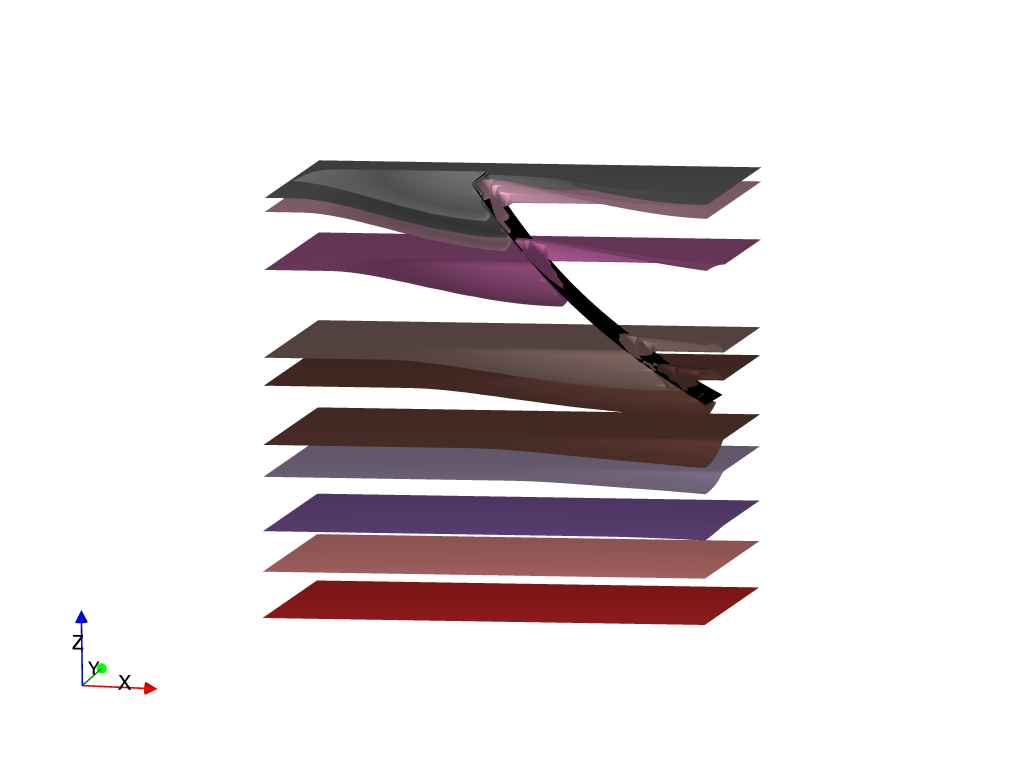

In [13]:
viewer = LavaVuModelViewer(model)
viewer.nelements = 1e5
viewer.add_model_surfaces(cmap='tab20')
viewer.rotation = rotation
viewer.border = 0

viewer.display()
images['surfaces'] = viewer.image_array()


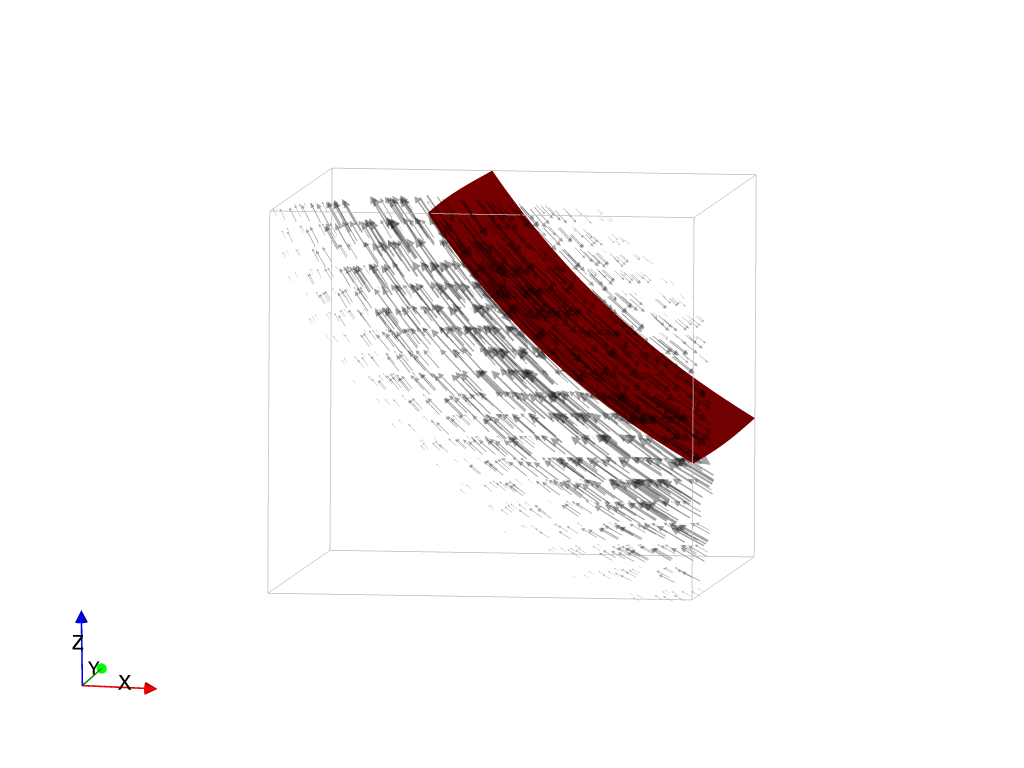

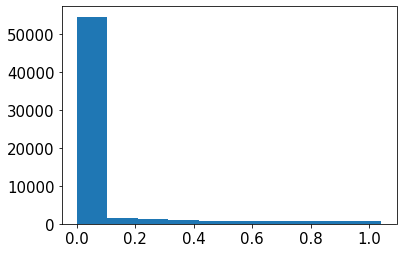

In [43]:
viewer.clear()
viewer.add_isosurface(fault[0],isovalue=0, colour='red')
# viewer.add_isosurface(fault[1],nslices=10, paint_with=fault[2])
# viewer.add_section(None,'y',viewer.bounding_box[1,1],colour='white')
# viewer.add_vector_data(verts,vec,'fault')
pts = model.regular_grid(rescale=False)[::1]
vec = fault[1].evaluate_gradient(pts)
vec /= np.linalg.norm(vec,axis=1)[:,None]
vec*=fault.evaluate_displacement(pts)[:,None]
mask = np.linalg.norm(vec,axis=1)>0.1
vec = vec[mask,:]
pts = pts[mask,:]
viewer.add_vector_data(pts[::6,:],vec[::6,:],'vector',normalise=False,colour=[0,0,0,.2])
viewer.rotation = rotation
# viewer.interactive()
viewer.border = 1
viewer.display()
images['fault_frame'] = viewer.image_array()

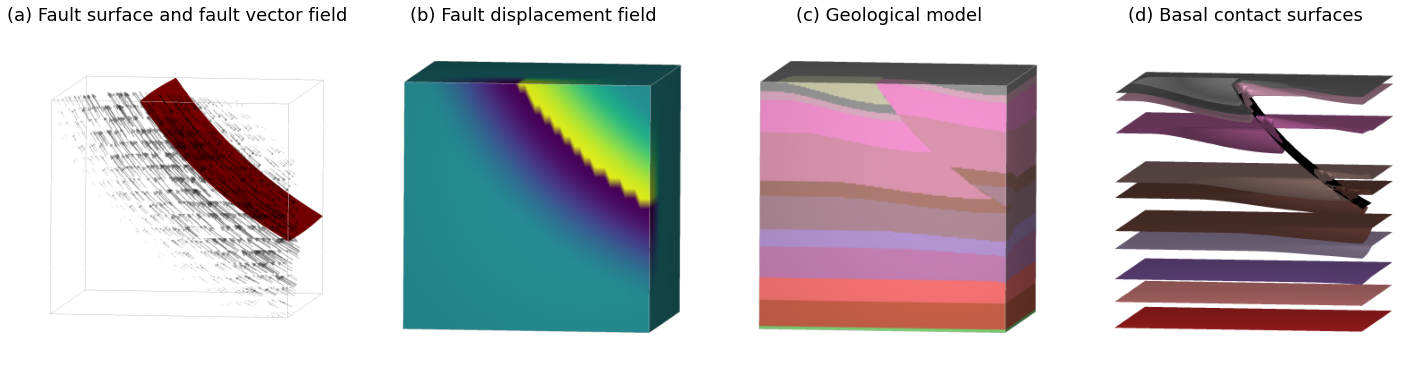

In [45]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.size'] = 15
fig, ax = plt.subplots(1,4,figsize=(20,20))
# ax[0][0].imshow(plt.imread(output+'/fault_frame.png')[75:705, 200:810,:])
# ax[0][0].set_title('A. Fault surface showing fault vector and fault extent field')
# ax[0][1].imshow(plt.imread(output+'/fault_displacement.png')[75:705, 200:810,:])
# ax[0][1].set_title('B. Fault displacement field')
# ax[1][0].imshow(plt.imread(output+'/stratigraphy.png')[75:705, 200:810,:])
# ax[1][0].set_title('C. Geological model')
# ax[1][1].imshow(plt.imread(output+'/surfaces.png')[75:705, 200:810,:])
# ax[1][1].set_title('D. Model surfaces')
ax[0].imshow(images['fault_frame'][50:420,120:500])
ax[0].set_title('(a) Fault surface and fault vector field')
ax[1].imshow(images['fault_displacement'][50:420,120:500])
ax[1].set_title('(b) Fault displacement field')
ax[2].imshow(images['stratigraphy'][50:420,120:500])
ax[2].set_title('(c) Geological model')
ax[3].imshow(images['surfaces'][50:420,120:500])
ax[3].set_title('(d) Basal contact surfaces')
for i in range(4):
#     for j in range(2):
    ax[i].axis('off')
plt.tight_layout()

## Displacement profile plot

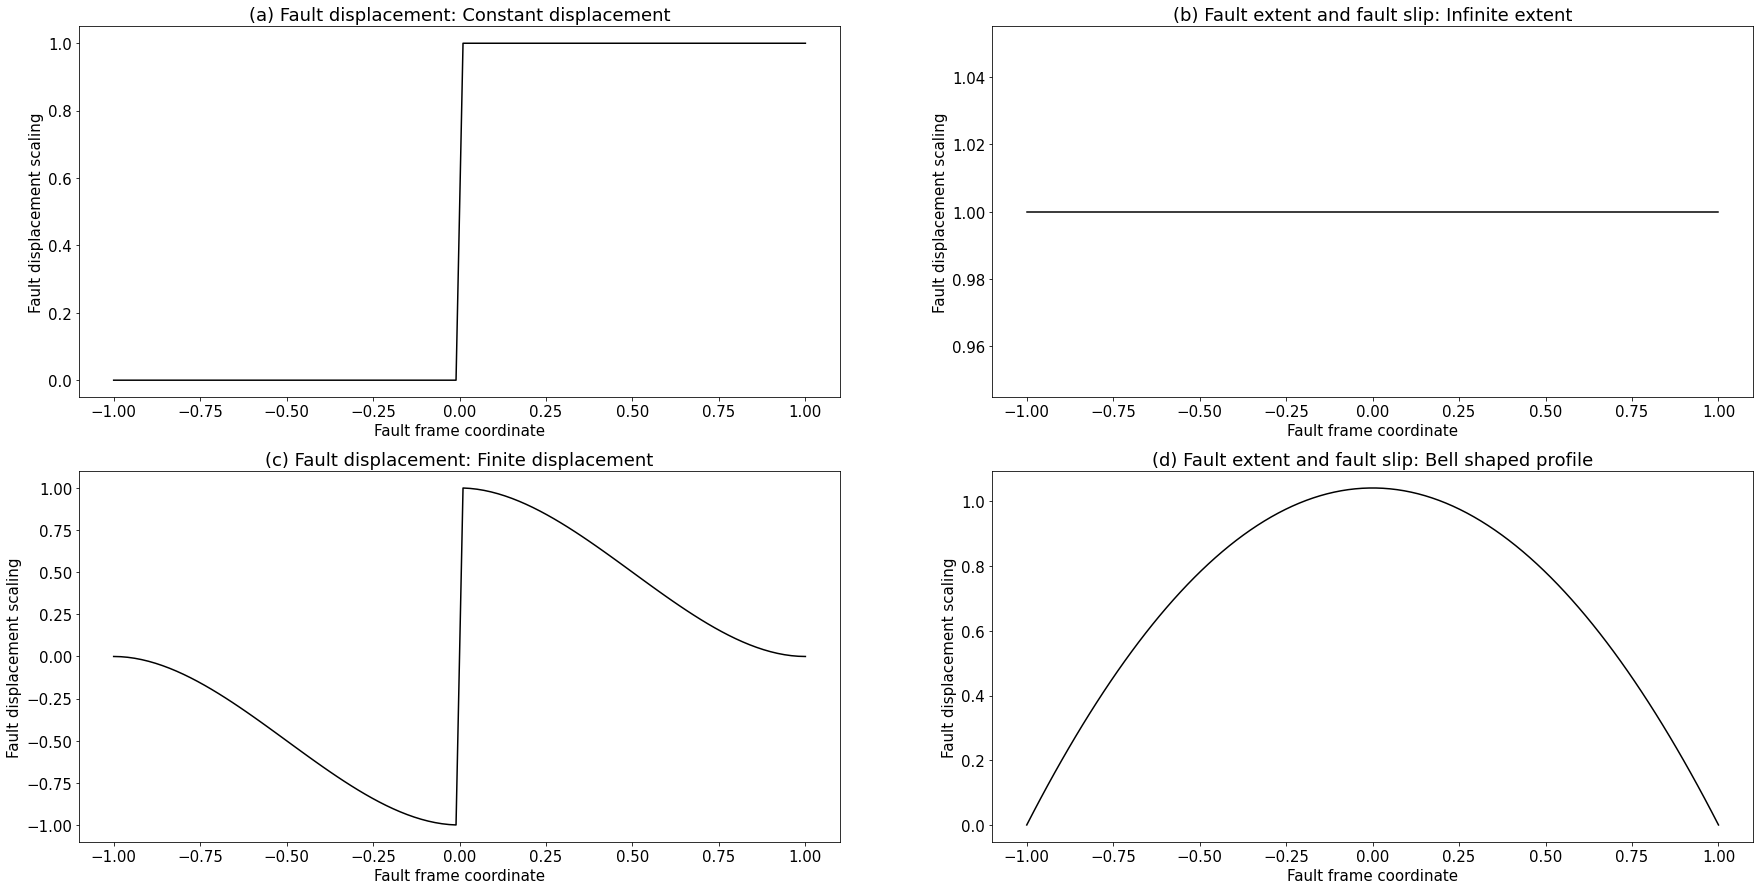

In [17]:
x = np.linspace(-1,1,100)
y = np.zeros(100)
y[x<0] = 0
y[x>0] = 1
fig, ax = plt.subplots(2,2,figsize=(30,15))
ax[0,0].set_title('(a) Fault displacement: Constant displacement')
ax[1,1].set_title('(d) Fault extent and fault slip: Bell shaped profile')
ax[1,0].set_title('(c) Fault displacement: Finite displacement')
ax[0,1].set_title('(b) Fault extent and fault slip: Infinite extent')

ax[1,0].plot(x,fault.faultfunction.gx(x),'k-')
ax[1,1].plot(x,fault.faultfunction.gz(x),'k-')
ax[0,1].plot(x,fault.faultfunction.gy(x),'k-')
ax[0,0].plot(x,y,'k-')
for i in range(2):
    for j in range(2):
        ax[i,j].set_xlabel('Fault frame coordinate')
        ax[i,j].set_ylabel('Fault displacement scaling')


## Export to webgl

In [18]:
view = LavaVuModelViewer(model)
view.add_isosurface(model['fault'],value=0)
view.add_vector_field(fault[1],locations=model.regular_grid()[::100],colour=[0,0,0,.2])
view.nsteps = np.array([200,200,200])
view.add_scalar_field(fault[0])
view.add_scalar_field(fault[1])
view.add_scalar_field(fault[2])
view.add_scalar_field(strati)
view.add_model(cmap='tab20')
view.interactive()

In [19]:
view.export_to_webgl('finite_fault_model')